In [498]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%pip install scikit-learn
from sklearn.preprocessing import OneHotEncoder

Note: you may need to restart the kernel to use updated packages.


In [499]:
import os

file_path = './mnist_test.csv'  # Update if needed
print("File exists:", os.path.exists(file_path))

data = pd.read_csv(file_path)

File exists: True


In [500]:
data.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [501]:
data.shape

(10000, 785)

In [502]:
x_training = data.iloc[0:8000, 1:].to_numpy()
y_training = data.iloc[0:8000, :1].to_numpy()

In [503]:
print(x_traning.shape)
y_traning.shape

(8000, 784)


(8000, 1)

In [504]:
print(x_traning)
print(y_traning)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[7]
 [2]
 [1]
 ...
 [5]
 [7]
 [8]]


In [505]:
x_test = data.iloc[8000:, 1:].to_numpy()
y_test = data.iloc[8000:, :1].to_numpy()


In [506]:
def one_hot_encode(y):
    encoder = OneHotEncoder(sparse_output=False, categories='auto')
    return encoder.fit_transform(y.reshape(-1, 1))

In [507]:
# =============== HELPER FUNCTIONS ================
def init_weights_and_biases(input_dim, hidden_dims, output_dim):
    """
    Initialize weights and biases using He initialization for ReLU networks
    
    Parameters:
    - input_dim: number of input features
    - hidden_dims: list of hidden layer dimensions
    - output_dim: number of output classes
    
    Returns:
    - params: dictionary containing weights and biases
    """
    params = {}
    layer_dims = [input_dim] + hidden_dims + [output_dim]
    
    for l in range(1, len(layer_dims)):
        # He initialization for ReLU - scale by sqrt(2/n)
        params[f'W{l}'] = np.random.randn(layer_dims[l-1], layer_dims[l]) * np.sqrt(2. / layer_dims[l-1])
        params[f'b{l}'] = np.zeros((1, layer_dims[l]))
        
    return params

In [508]:
# =============== ACTIVATION FUNCTIONS ================
def relu(Z):
    """
    ReLU activation function: max(0, Z)
    
    Parameters:
    - Z: pre-activation matrix
    
    Returns:
    - A: post-activation matrix
    """
    return np.maximum(0, Z)

def relu_derivative(Z):
    """
    Derivative of ReLU activation function
    
    Parameters:
    - Z: pre-activation matrix
    
    Returns:
    - derivative matrix (1 where Z > 0, 0 otherwise)
    """
    return (Z > 0).astype(float)

def softmax(Z):
    """
    Stable softmax function to prevent overflow
    
    Parameters:
    - Z: pre-activation matrix
    
    Returns:
    - A: post-activation matrix (probabilities that sum to 1)
    """
    # Subtract max for numerical stability
    Z_shifted = Z - np.max(Z, axis=1, keepdims=True)
    exp_Z = np.exp(Z_shifted)
    return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)


In [509]:
# =============== LOSS FUNCTION ================
def cross_entropy_loss(y_true, y_pred):
    """
    Calculate cross-entropy loss
    
    Parameters:
    - y_true: true labels (one-hot encoded)
    - y_pred: predicted probabilities
    
    Returns:
    - loss: average cross-entropy loss
    """
    m = y_true.shape[0]  # Number of examples
    # Add small epsilon to prevent log(0)
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # Clip values to avoid numerical issues
    loss = -np.sum(y_true * np.log(y_pred)) / m
    return loss


In [510]:
def Dense(x, w, b, activation=None):
    """
    Dense layer forward pass
    """
    z = np.dot(x, w) + b  # Linear transformation

    if activation == 'relu':
        a = relu(z)
    elif activation == 'softmax':
        a = softmax(z)
    else:
        a = z  # Linear activation (default)

    return z, a  # Returning both pre-activation and post-activation values


In [511]:
# =============== FORWARD PROPAGATION ================
def forward_propagation(X, params):
    """
    Forward propagation through the network
    
    Parameters:
    - X: input data
    - params: dictionary containing weights and biases
    
    Returns:
    - cache: dictionary containing Z and A values for backpropagation
    - A_final: final layer activations (predictions)
    """
    num_layers = len(params) // 2
    cache = {}
    A = X  # Input layer activation
    
    # Hidden layers with ReLU
    for l in range(1, num_layers):
        W = params[f'W{l}']
        b = params[f'b{l}']
        
        Z = np.dot(A, W) + b
        A = relu(Z)
        
        cache[f'Z{l}'] = Z
        cache[f'A{l}'] = A
    
    # Output layer with softmax
    W = params[f'W{num_layers}']
    b = params[f'b{num_layers}']
    
    Z = np.dot(A, W) + b
    A = softmax(Z)
    
    cache[f'Z{num_layers}'] = Z
    cache[f'A{num_layers}'] = A
    
    return cache, A


In [512]:
# =============== BACKWARD PROPAGATION ================
def backward_propagation(X, y_true, params, cache):
    """
    Backward propagation to compute gradients
    
    Parameters:
    - X: input data
    - y_true: true labels (one-hot encoded)
    - params: dictionary containing weights and biases
    - cache: dictionary containing Z and A values from forward pass
    
    Returns:
    - grads: dictionary containing gradients for all parameters
    """
    m = X.shape[0]  # Number of examples
    num_layers = len(params) // 2
    grads = {}
    
    # Output layer (softmax + cross-entropy derivative is simple)
    y_pred = cache[f'A{num_layers}']
    dZ = y_pred - y_true
    
    # Get activation from previous layer (or input if only one layer)
    if num_layers == 1:
        A_prev = X
    else:
        A_prev = cache[f'A{num_layers - 1}']
    
    # Calculate gradients for output layer
    grads[f'dW{num_layers}'] = (1/m) * np.dot(A_prev.T, dZ)
    grads[f'db{num_layers}'] = (1/m) * np.sum(dZ, axis=0, keepdims=True)
    
    # Backpropagate through hidden layers
    dA = np.dot(dZ, params[f'W{num_layers}'].T)
    
    for l in reversed(range(1, num_layers)):
        # Get cached values
        Z = cache[f'Z{l}']
        
        # Calculate gradients for current layer
        dZ = dA * relu_derivative(Z)
        
        # Get activation from previous layer (or input if first layer)
        if l == 1:
            A_prev = X
        else:
            A_prev = cache[f'A{l-1}']
        
        # Calculate gradients
        grads[f'dW{l}'] = (1/m) * np.dot(A_prev.T, dZ)
        grads[f'db{l}'] = (1/m) * np.sum(dZ, axis=0, keepdims=True)
        
        # Calculate gradient for previous layer activation (if not the first layer)
        if l > 1:
            dA = np.dot(dZ, params[f'W{l}'].T)
    
    return grads

In [513]:
# =============== GRADIENT CLIPPING ================
def clip_gradients(grads, threshold=1.0):
    """
    Clip gradients to prevent exploding gradients
    
    Parameters:
    - grads: dictionary containing gradients
    - threshold: maximum allowed gradient magnitude
    
    Returns:
    - clipped_grads: dictionary containing clipped gradients
    """
    clipped_grads = {}
    for key, grad in grads.items():
        clipped_grads[key] = np.clip(grad, -threshold, threshold)
    return clipped_grads


In [514]:
# =============== PARAMETER UPDATE ================
def update_parameters(params, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Parameters:
    - params: dictionary containing weights and biases
    - grads: dictionary containing gradients
    - learning_rate: learning rate for gradient descent
    
    Returns:
    - updated_params: dictionary containing updated parameters
    """
    num_layers = len(params) // 2
    updated_params = params.copy()
    
    for l in range(1, num_layers + 1):
        updated_params[f'W{l}'] = params[f'W{l}'] - learning_rate * grads[f'dW{l}']
        updated_params[f'b{l}'] = params[f'b{l}'] - learning_rate * grads[f'db{l}']
    
    return updated_params


In [515]:
# =============== TRAINING FUNCTION ================
def train_neural_network(X_train, y_train, hidden_dims, output_dim, epochs=1000, learning_rate=0.01, 
                        batch_size=None, verbose=True, clip_threshold=1.0):
    """
    Train a neural network
    
    Parameters:
    - X_train: training inputs
    - y_train: training labels (one-hot encoded)
    - hidden_dims: list of hidden layer dimensions
    - output_dim: number of output classes
    - epochs: number of training epochs
    - learning_rate: learning rate for gradient descent
    - batch_size: size of mini-batches (None = use all data)
    - verbose: whether to print loss during training
    - clip_threshold: threshold for gradient clipping
    
    Returns:
    - params: trained parameters
    - loss_history: list of loss values during training
    """
    # Initialize parameters
    input_dim = X_train.shape[1]
    params = init_weights_and_biases(input_dim, hidden_dims, output_dim)
    loss_history = []
    m = X_train.shape[0]
    
    # Mini-batch settings
    if batch_size is None:
        batch_size = m
    
    # Training loop
    for epoch in range(epochs):
        # Mini-batch training
        for batch_start in range(0, m, batch_size):
            batch_end = min(batch_start + batch_size, m)
            X_batch = X_train[batch_start:batch_end]
            y_batch = y_train[batch_start:batch_end]
            
            # Forward propagation
            cache, y_pred = forward_propagation(X_batch, params)
            
            # Calculate loss
            loss = cross_entropy_loss(y_batch, y_pred)
            
            # Check for NaN loss (model divergence)
            if np.isnan(loss):
                if verbose:
                    print(f"NaN loss detected at epoch {epoch}. Training stopped.")
                return params, loss_history
            
            # Backward propagation
            grads = backward_propagation(X_batch, y_batch, params, cache)
            
            # Clip gradients
            clipped_grads = clip_gradients(grads, threshold=clip_threshold)
            
            # Update parameters
            params = update_parameters(params, clipped_grads, learning_rate)
        
        # Record loss after each epoch
        loss_history.append(loss)
        
        # Print progress
        if verbose and (epoch % 100 == 0 or epoch == epochs - 1):
            print(f'Epoch {epoch}, Loss: {loss:.6f}')
    
    return params, loss_history

In [516]:
def predict(X, params):
    """
    Make predictions using the trained model
    
    Parameters:
    - X: input data
    - params: trained model parameters
    
    Returns:
    - predictions: class predictions
    - probabilities: probability for each class
    """
    # Forward pass
    _, probabilities = forward_propagation(X, params)
    
    # Get class predictions
    predictions = np.argmax(probabilities, axis=1)
    
    return predictions, probabilities

# =============== EVALUATION FUNCTION ================
def evaluate_model(X, y_true, params):
    """
    Evaluate model performance
    
    Parameters:
    - X: input data
    - y_true: true labels (one-hot encoded)
    - params: trained model parameters
    
    Returns:
    - accuracy: prediction accuracy
    - loss: cross-entropy loss
    """
    # Get predictions
    _, y_pred = forward_propagation(X, params)
    
    # Calculate loss
    loss = cross_entropy_loss(y_true, y_pred)
    
    # Calculate accuracy
    pred_classes = np.argmax(y_pred, axis=1)
    true_classes = np.argmax(y_true, axis=1)
    accuracy = np.mean(pred_classes == true_classes)
    
    return accuracy, loss

Starting training...
Network architecture: 784 -> 25 -> 15 -> 10
Training on 8000 samples, testing on 2000 samples
Epoch 0, Loss: 2.302321
Epoch 100, Loss: 2.116333
Epoch 200, Loss: 30.414544
Epoch 300, Loss: 2.120377
Epoch 400, Loss: 1.993584
Epoch 500, Loss: 2.125339
Epoch 600, Loss: 2.120538
Epoch 700, Loss: 2.115365
Epoch 800, Loss: 2.110493
Epoch 900, Loss: 2.106007
Epoch 999, Loss: 2.102023


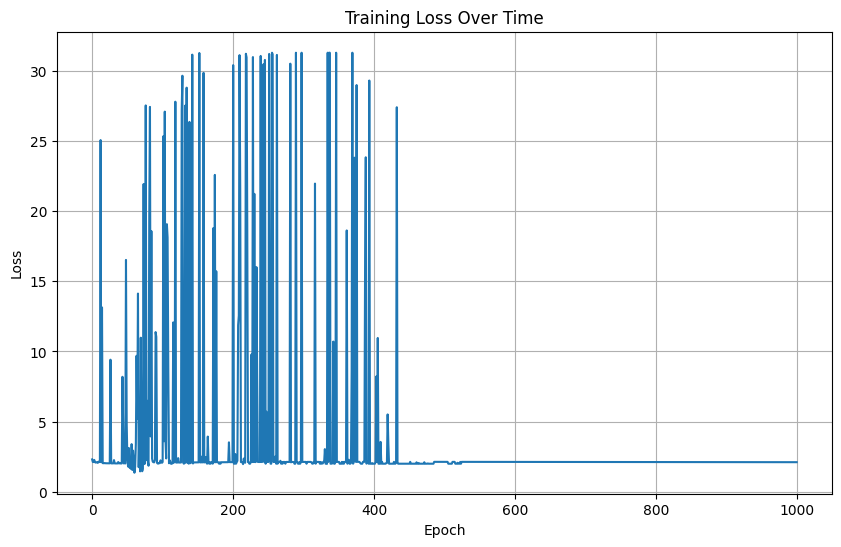

Training accuracy: 0.2146, Training loss: 1.9678
Test accuracy: 0.2095, Test loss: 2.0051
Confusion Matrix:
[[  0   0 207   0   0   0   0   0   0   0]
 [  0 222   8   0   0   0   0   0   0   0]
 [  0   1 197   0   0   0   0   0   0   0]
 [  0   0 207   0   0   0   0   0   0   0]
 [  0   0 194   0   0   0   0   0   0   0]
 [  0   0 169   0   0   0   0   0   0   0]
 [  0   0 202   0   0   0   0   0   0   0]
 [  0   0 215   0   0   0   0   0   0   0]
 [  0   1 186   0   0   0   0   0   0   0]
 [  0   0 191   0   0   0   0   0   0   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       207
           1       0.99      0.97      0.98       230
           2       0.11      0.99      0.20       198
           3       0.00      0.00      0.00       207
           4       0.00      0.00      0.00       194
           5       0.00      0.00      0.00       169
           6       0.00      0.00      0.00       202
    

/Users/krutarthpatel/Desktop/ML-data/course 2/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/krutarthpatel/Desktop/ML-data/course 2/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/krutarthpatel/Desktop/ML-data/course 2/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [517]:
y_training_encoded = one_hot_encode(y_training)
y_test_encoded = one_hot_encode(y_test)

# Define your specific 3-layer architecture
input_dim = x_training.shape[1]  # Number of features
hidden_layers = [25, 15]         # First hidden layer: 25 units, Second hidden layer: 15 units
output_classes = 10              # Output layer: 10 units (classes)

# Training parameters
epochs = 1000
learning_rate = 0.01
batch_size = 64
gradient_clip = 1.0  # Gradient clipping threshold

print("Starting training...")
print(f"Network architecture: {input_dim} -> {hidden_layers[0]} -> {hidden_layers[1]} -> {output_classes}")
print(f"Training on {x_training.shape[0]} samples, testing on {x_test.shape[0]} samples")

# Train the model
trained_params, loss_history = train_neural_network(
    X_train=x_training,
    y_train=y_training_encoded,
    hidden_dims=hidden_layers,
    output_dim=output_classes,
    epochs=epochs,
    learning_rate=learning_rate,
    batch_size=batch_size,
    verbose=True,
    clip_threshold=gradient_clip
)

# Plot the loss curve to visualize training progress
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Evaluate on training data
train_accuracy, train_loss = evaluate_model(x_training, y_training_encoded, trained_params)
print(f"Training accuracy: {train_accuracy:.4f}, Training loss: {train_loss:.4f}")

# Evaluate on test data
test_accuracy, test_loss = evaluate_model(x_test, y_test_encoded, trained_params)
print(f"Test accuracy: {test_accuracy:.4f}, Test loss: {test_loss:.4f}")

# Make predictions on test data
predictions, probabilities = predict(x_test, trained_params)

# Optional: Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
true_classes = np.argmax(y_test_encoded, axis=1)

print("Confusion Matrix:")
conf_matrix = confusion_matrix(true_classes, predictions)
print(conf_matrix)

print("\nClassification Report:")
class_report = classification_report(true_classes, predictions)
print(class_report)

# Visualize some predictions (optional)
def visualize_predictions(X, y_true, predictions, probabilities, num_samples=5):
    """
    Visualize some predictions if your data is an image dataset
    """
    import random
    indices = random.sample(range(len(X)), num_samples)
    
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i, idx in enumerate(indices):
        true_label = np.argmax(y_true[idx])
        pred_label = predictions[idx]
        confidence = probabilities[idx, pred_label] * 100
        
        # If your data represents images, you can visualize them
        # For MNIST-like datasets, you would do:
        # axes[i].imshow(X[idx].reshape(28, 28), cmap='gray')
        
        # Otherwise, just display the prediction information
        axes[i].text(0.5, 0.5, f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%",
                    ha='center', va='center')
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        if true_label == pred_label:
            axes[i].set_title("Correct", color='green')
        else:
            axes[i].set_title("Wrong", color='red')
    
    plt.tight_layout()
    plt.show()

# Uncomment to visualize some predictions
# visualize_predictions(x_test, y_test_encoded, predictions, probabilities)

In [518]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def visualize_mnist_predictions(X_test, y_test, params, num_samples=10, random_state=None):
    """
    Visualize MNIST predictions made by the trained model
    
    Parameters:
    - X_test: test images
    - y_test: test labels (one-hot encoded)
    - params: trained model parameters
    - num_samples: number of samples to visualize
    - random_state: random seed for reproducibility
    
    Returns:
    - None (displays visualizations)
    """
    # Get predictions from the model
    predictions, probabilities = predict(X_test, params)
    
    # Convert one-hot encoded labels to class indices
    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        true_labels = np.argmax(y_test, axis=1)
    else:
        true_labels = y_test
    
    # Select random samples
    if random_state is not None:
        np.random.seed(random_state)
    
    indices = np.random.choice(len(X_test), size=num_samples, replace=False)
    
    # Create a grid to display images
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 1.5, 3))
    
    for i, idx in enumerate(indices):
        # Get the image and reshape it to 28x28
        img = X_test[idx]
        img_reshaped = img.reshape(28, 28)
        
        # Get true and predicted labels
        true_label = true_labels[idx]
        pred_label = predictions[idx]
        confidence = probabilities[idx, pred_label] * 100
        
        # Display the image
        axes[0, i].imshow(img_reshaped, cmap='gray')
        axes[0, i].set_title(f"True: {true_label}")
        axes[0, i].axis('off')
        
        # Display the prediction confidence
        color = 'green' if true_label == pred_label else 'red'
        axes[1, i].bar(range(10), probabilities[idx], color='lightgray')
        axes[1, i].bar(pred_label, probabilities[idx, pred_label], color=color)
        axes[1, i].set_title(f"Pred: {pred_label} ({confidence:.1f}%)", color=color)
        axes[1, i].set_xticks(range(10))
        axes[1, i].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    return predictions, true_labels

def plot_confusion_matrix(y_true, y_pred, classes=range(10)):
    """
    Plot a confusion matrix for the MNIST predictions
    
    Parameters:
    - y_true: true labels
    - y_pred: predicted labels
    - classes: class names/numbers
    
    Returns:
    - None (displays confusion matrix)
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    
    # Add labels
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    # Add text annotations
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def plot_misclassified_examples(X_test, y_test, predictions, probabilities, num_examples=25):
    """
    Plot misclassified examples to analyze model errors
    
    Parameters:
    - X_test: test images
    - y_test: test labels (can be one-hot encoded)
    - predictions: model predictions
    - probabilities: prediction probabilities
    - num_examples: number of misclassified examples to show
    
    Returns:
    - None (displays visualization)
    """
    # Convert one-hot encoded labels to class indices if needed
    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        true_labels = np.argmax(y_test, axis=1)
    else:
        true_labels = y_test
    
    # Find misclassified examples
    misclassified = np.where(predictions != true_labels)[0]
    
    if len(misclassified) == 0:
        print("No misclassified examples found!")
        return
    
    # Select a subset if there are too many
    num_examples = min(num_examples, len(misclassified))
    indices = np.random.choice(misclassified, size=num_examples, replace=False)
    
    # Determine grid size
    grid_size = int(np.ceil(np.sqrt(num_examples)))
    
    # Create figure
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    axes = axes.flatten()
    
    for i, idx in enumerate(indices):
        if i >= num_examples:
            break
            
        img = X_test[idx].reshape(28, 28)
        true_label = true_labels[idx]
        pred_label = predictions[idx]
        confidence = probabilities[idx, pred_label] * 100
        
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%", 
                          color='red')
        axes[i].axis('off')
    
    # Turn off any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.suptitle("Misclassified Examples", fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.show()

def evaluate_mnist_model(X_test, y_test_encoded, trained_params):
    """
    Comprehensive evaluation of the MNIST model
    
    Parameters:
    - X_test: test images
    - y_test_encoded: one-hot encoded test labels
    - trained_params: trained model parameters
    
    Returns:
    - None (displays evaluations)
    """
    # Get predictions
    predictions, probabilities = predict(X_test, trained_params)
    true_labels = np.argmax(y_test_encoded, axis=1)
    
    # Calculate accuracy
    accuracy = np.mean(predictions == true_labels)
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # Display classification report
    print("\nClassification Report:")
    print(classification_report(true_labels, predictions))
    
    # Plot confusion matrix
    plot_confusion_matrix(true_labels, predictions)
    
    # Visualize sample predictions
    visualize_mnist_predictions(X_test, y_test_encoded, trained_params, num_samples=10, random_state=42)
    
    # Show misclassified examples
    plot_misclassified_examples(X_test, y_test_encoded, predictions, probabilities, num_examples=25)

# Usage example:
"""
# After training your model:
trained_params, loss_history = train_neural_network(
    X_train=x_training,
    y_train=y_training_encoded,
    hidden_dims=[25, 15],
    output_dim=10,
    epochs=1000,
    learning_rate=0.01,
    batch_size=64,
    verbose=True,
    clip_threshold=1.0
)

# Evaluate the model in detail
evaluate_mnist_model(x_test, y_test_encoded, trained_params)
"""

'\n# After training your model:\ntrained_params, loss_history = train_neural_network(\n    X_train=x_training,\n    y_train=y_training_encoded,\n    hidden_dims=[25, 15],\n    output_dim=10,\n    epochs=1000,\n    learning_rate=0.01,\n    batch_size=64,\n    verbose=True,\n    clip_threshold=1.0\n)\n\n# Evaluate the model in detail\nevaluate_mnist_model(x_test, y_test_encoded, trained_params)\n'

Epoch 0, Loss: 2.012390
Epoch 100, Loss: 29.799782
Epoch 200, Loss: 1.730357
Epoch 300, Loss: 1.728698
Epoch 400, Loss: 1.728157
Epoch 500, Loss: 1.726556
Epoch 600, Loss: 1.727024
Epoch 700, Loss: 1.727046
Epoch 800, Loss: 1.727161
Epoch 900, Loss: 1.785800
Epoch 999, Loss: 1.727241
Test Accuracy: 0.3050

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       207
           1       0.89      0.99      0.94       230
           2       0.12      0.95      0.22       198
           3       0.00      0.00      0.00       207
           4       0.00      0.00      0.00       194
           5       0.00      0.00      0.00       169
           6       0.00      0.00      0.00       202
           7       0.00      0.00      0.00       215
           8       0.00      0.00      0.00       187
           9       0.00      0.00      0.00       191

    accuracy                           0.30      2000
   macro avg       

/Users/krutarthpatel/Desktop/ML-data/course 2/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/krutarthpatel/Desktop/ML-data/course 2/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/krutarthpatel/Desktop/ML-data/course 2/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

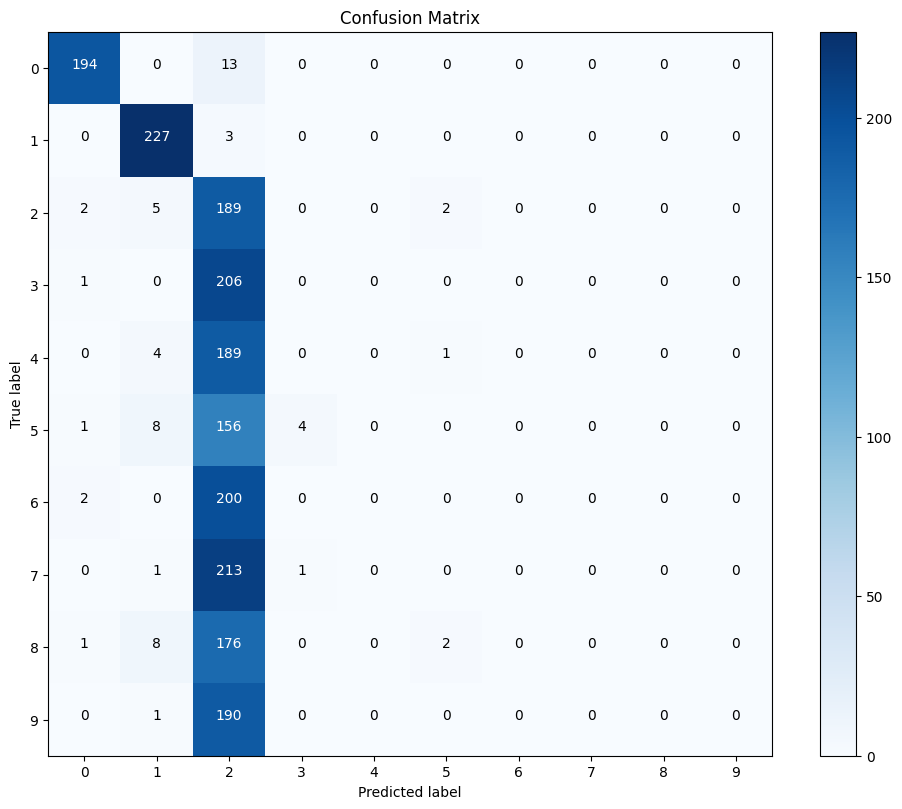

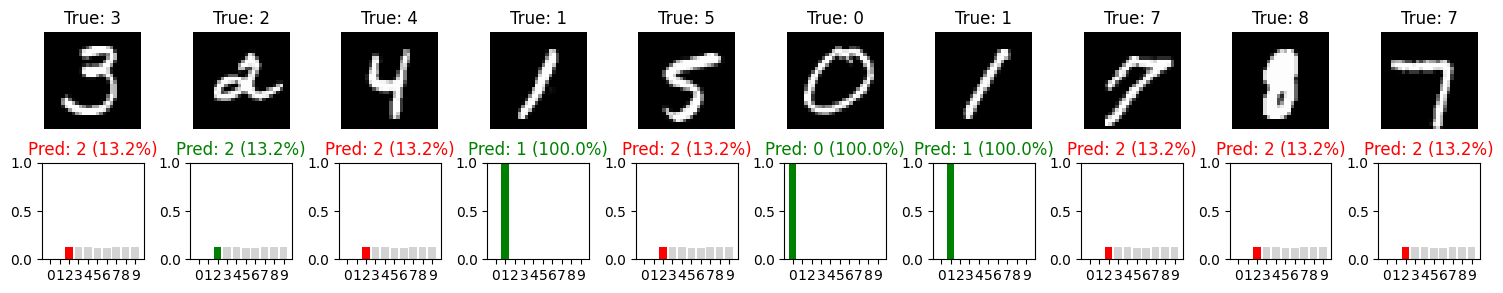

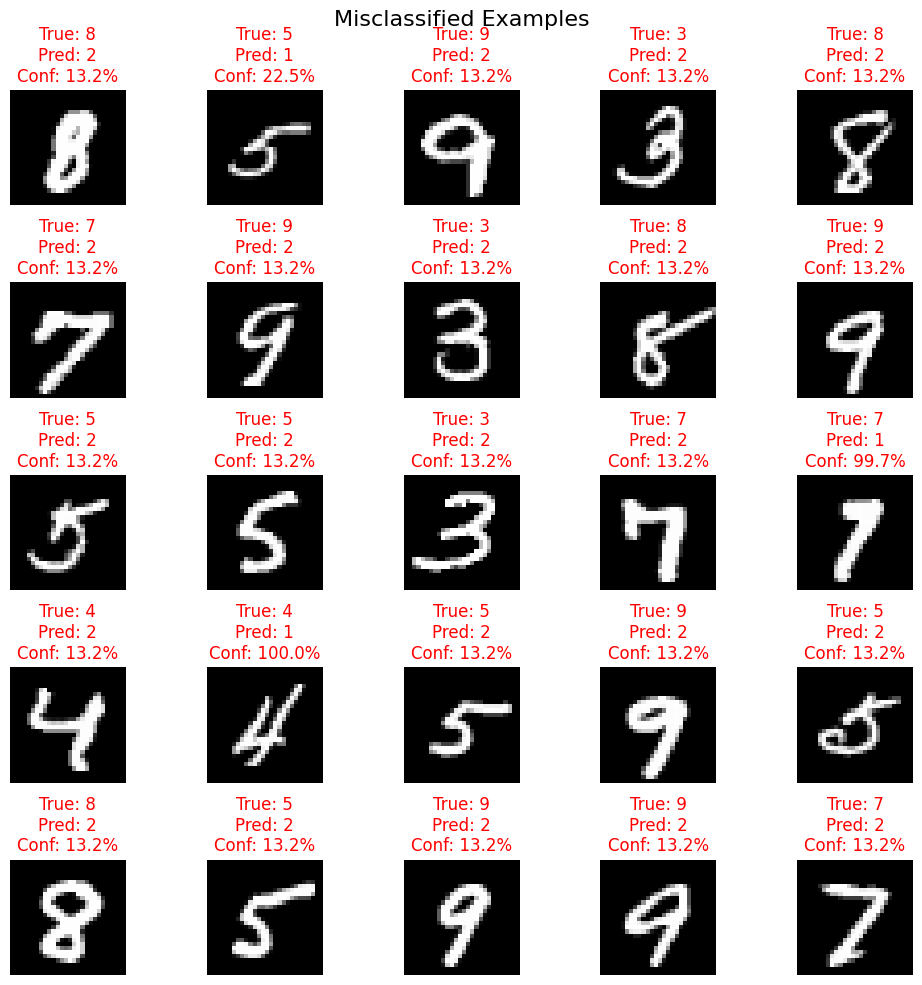

In [519]:
trained_params, loss_history = train_neural_network(
    X_train=x_training,
    y_train=y_training_encoded,
    hidden_dims=[25, 15],
    output_dim=10,
    epochs=1000,
    learning_rate=0.01,
    batch_size=64,
    verbose=True,
    clip_threshold=1.0
)

evaluate_mnist_model(x_test, y_test_encoded, trained_params)